In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})
import re

In [2]:
sales = pd.read_csv('../data/interim/sales_train_etl.csv', parse_dates=['date'])
shops = pd.read_csv('../data/interim/shops_etl.csv')
items = pd.read_csv('../data/interim/items_etl.csv')
item_cat = pd.read_csv('../data/interim/item_categories_etl.csv')

In [3]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-06,0,25,2554,1709.05,1.0
3,2013-01-15,0,25,2555,1099.00,1.0
4,2013-01-10,0,25,2564,349.00,1.0


### Sales - date and date block

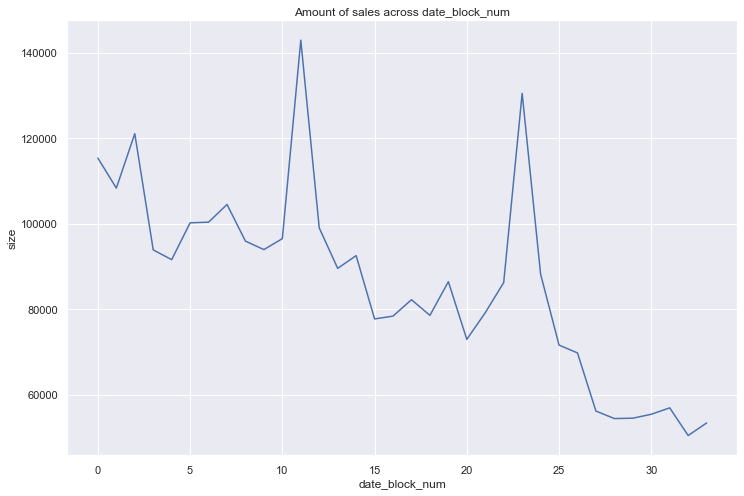

In [4]:
sns.lineplot(data=sales.groupby(['date_block_num'], as_index=False).size(), x='date_block_num', y='size')
plt.title('Amount of sales across date_block_num');

По количеству продаж в каждый месяц наблюдается общий тренд на снижение, но есть пики на значениях *11* и *23* - эти значения соответсвуют декабрю. Еще можно заметить небольшие подъемы на значениях, соответсвующих августу и марту.

Проанализируем по остальным месяцам и дням недели:

In [5]:
sales['month'] = sales['date_block_num'] % 12 + 1
sales['year'] = sales['date'].dt.year
sales['day_of_week'] = sales['date'].dt.dayofweek

#### Month

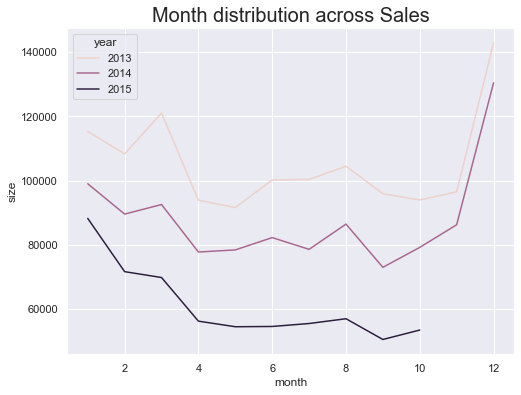

In [6]:
sns.set(rc={'figure.figsize':(8,6)})
sns.lineplot(data=sales.groupby(['month', 'year'], as_index=False).size(), x='month', y='size', hue='year')
plt.title('Month distribution across Sales', fontsize=20);

#### Day of week

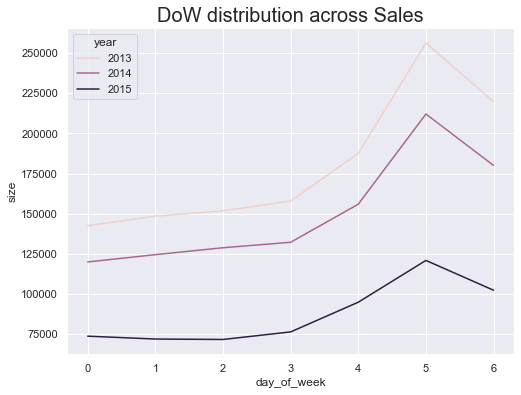

In [7]:
sns.lineplot(data=sales.groupby(['day_of_week', 'year'], as_index=False).size(), x='day_of_week', y='size', hue='year')
sns.set(rc={'figure.figsize':(6,4)})
plt.title('DoW distribution across Sales', fontsize=20);

Больше всего покупок совершают на выходных.

### shops and items

In [8]:
sales_merged = sales.merge(shops, on='shop_id').merge(items, on='item_id').merge(item_cat, on='item_category_id')

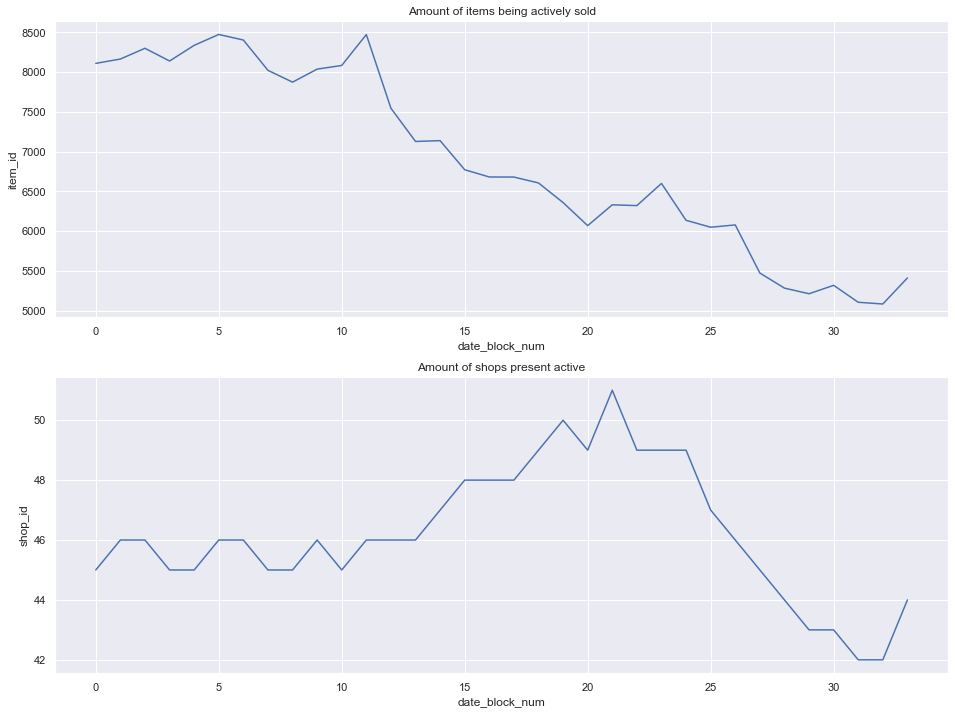

In [23]:
fig, axs = plt.subplots(nrows=2)
sns.set(rc={'figure.figsize':(10,12)})
sns.lineplot(data=sales_merged.groupby(['date_block_num'], as_index=False).agg({'item_id':'nunique'}), y='item_id', x='date_block_num', ax=axs[0]);
axs[0].set_title('Amount of items being actively sold')
sns.lineplot(data=sales_merged.groupby(['date_block_num'], as_index=False).agg({'shop_id':'nunique'}), y='shop_id', x='date_block_num',ax=axs[1]);
axs[1].set_title('Amount of shops present active');

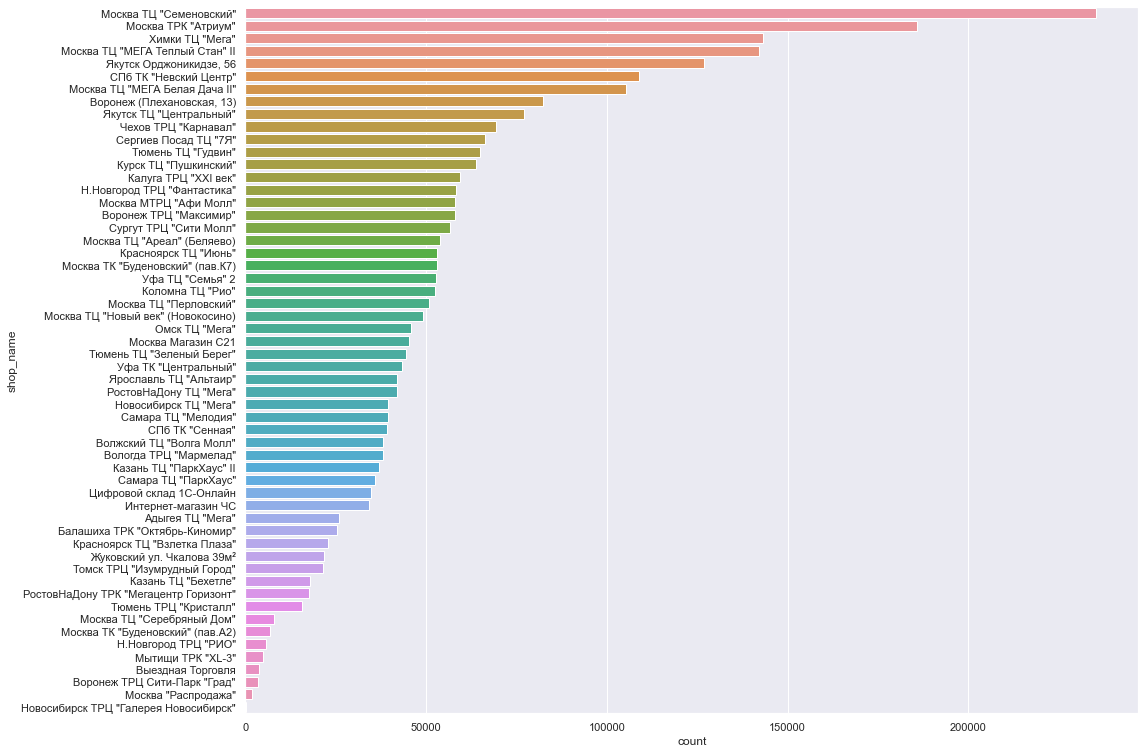

In [10]:
sns.set(rc={'figure.figsize':(16,13)})
sns.countplot(data=sales_merged, y="shop_name", order = sales_merged['shop_name'].value_counts().index);

Посмотрим на динамику продаж в разных магазинах.

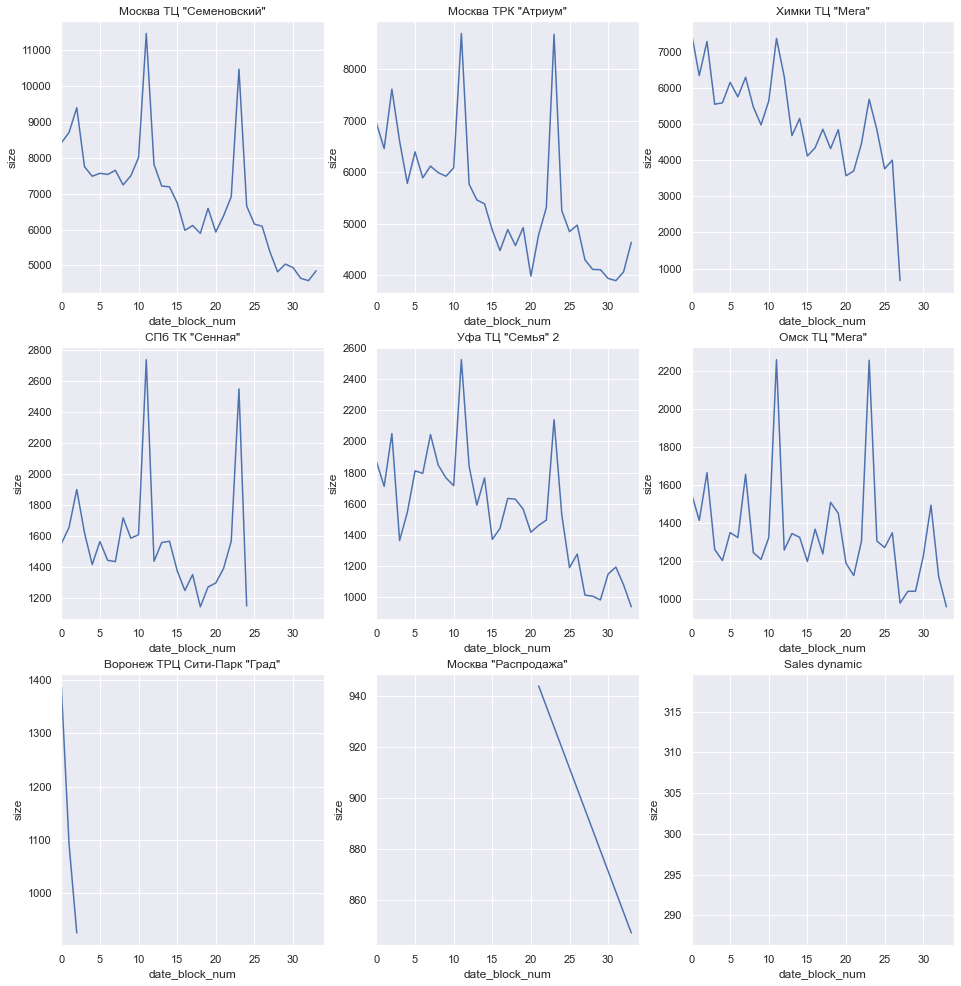

In [11]:
sns.set(rc={'figure.figsize':(16,17)})
fig, axs = plt.subplots(ncols=3, nrows=3)
cities = ['Москва ТЦ "Семеновский"', 'Москва ТРК "Атриум"', 'Химки ТЦ "Мега"', 'СПб ТК "Сенная"', 'Уфа ТЦ "Семья" 2', 'Омск ТЦ "Мега"', 'Воронеж ТРЦ Сити-Парк "Град"', 'Москва "Распродажа"', 'Новосибирск ТРЦ "Галерея Новосибирск"']
for city, ax in zip(cities, axs.flatten()):
    sns.lineplot(data=sales_merged[sales_merged['shop_name'] == city].groupby(['date_block_num'], as_index=False).size(), x='date_block_num', y='size', ax=ax)
    ax.set_title(city)
    ax.set_xlim([0,34])
plt.title('Sales dynamic');

In [12]:
sales_merged['shop_weeks_since_start'] = (sales_merged['date'] - sales['date'].min()).dt.days / 7

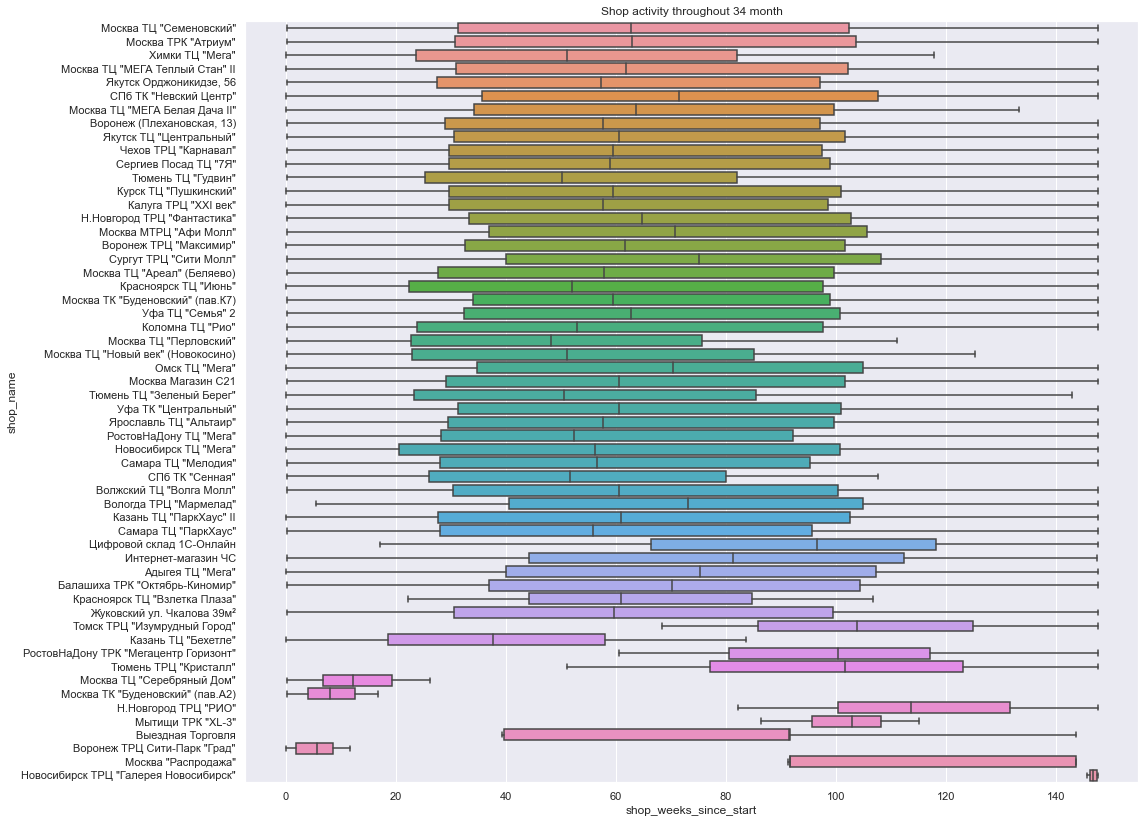

In [13]:
sns.set(rc={'figure.figsize':(16,14)})
sns.boxplot(data=sales_merged, y='shop_name', x='shop_weeks_since_start', order = sales_merged['shop_name'].value_counts().index)
plt.title('Shop activity throughout 34 month');

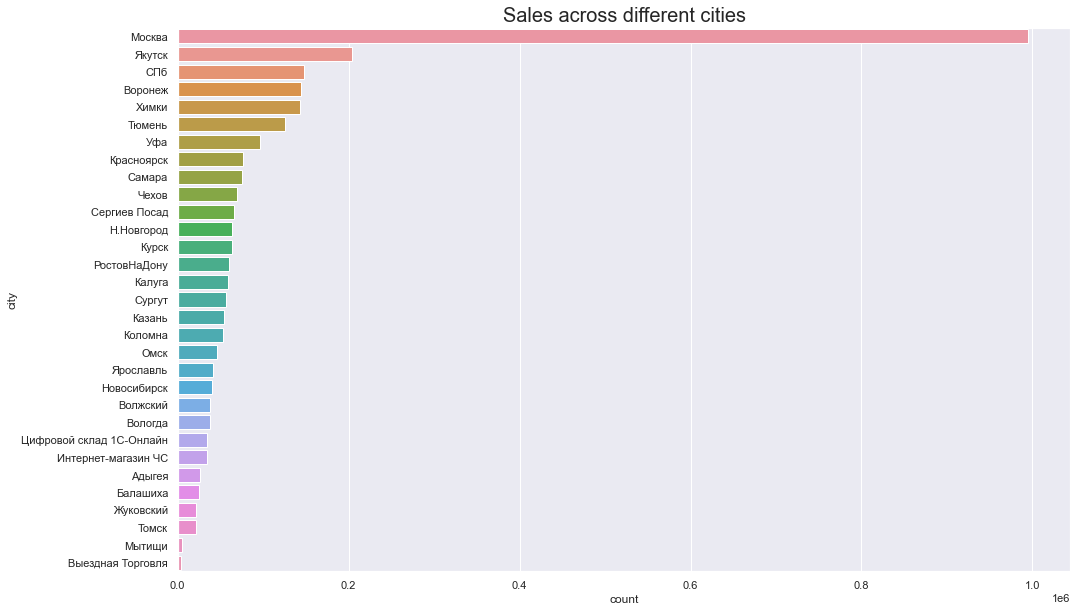

In [14]:
sales_merged['city'] = sales_merged['shop_name'].apply(lambda s: re.split(' (ТРЦ|ТЦ|ТК|ТРК|МТРЦ|\(|\"|ул)',s)[0])
sales_merged['city'].replace({'Якутск Орджоникидзе, 56': 'Якутск', 'Москва Магазин С21': 'Москва'}, inplace=True)

sns.set(rc={'figure.figsize':(16,10)})
sns.countplot(data=sales_merged, y="city", order = sales_merged['city'].value_counts().index);
plt.title('Sales across different cities', fontsize=20);

Разных предметов слишком много, чтобы отобразить в одном графике, но можно рассмотреть категории. Можно заметить, что большинство категорий состоит из двух частей, разделенных дефисом, из которых первая - более глобальная.

In [15]:
item_cat.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


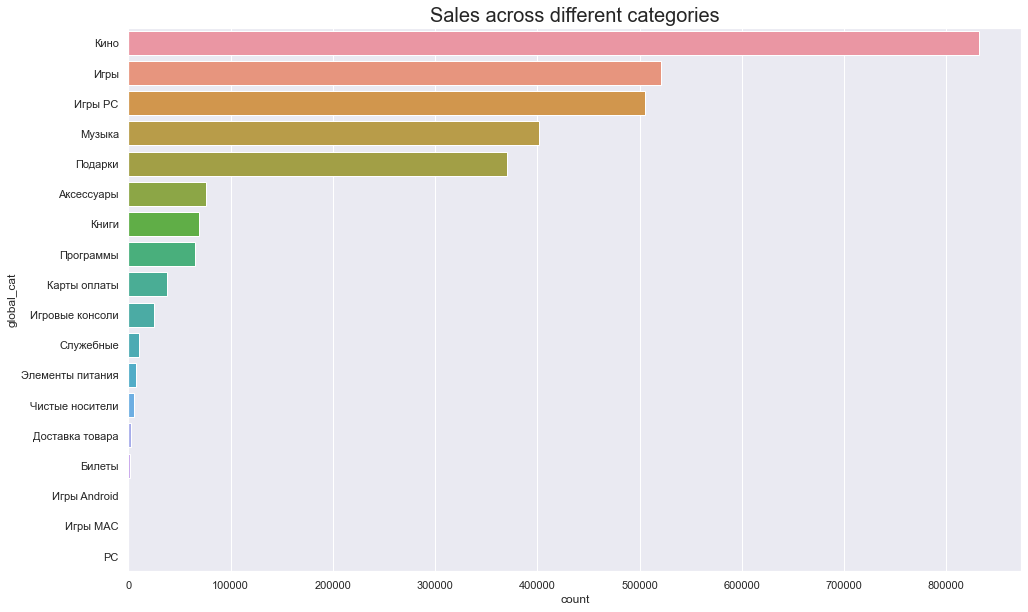

In [16]:
sales_merged['global_cat'] = sales_merged['item_category_name'].apply(lambda s: re.split(' (-|\()', s)[0])

sns.countplot(data=sales_merged, y="global_cat", order = sales_merged['global_cat'].value_counts().index);
plt.title('Sales across different categories', fontsize=20);

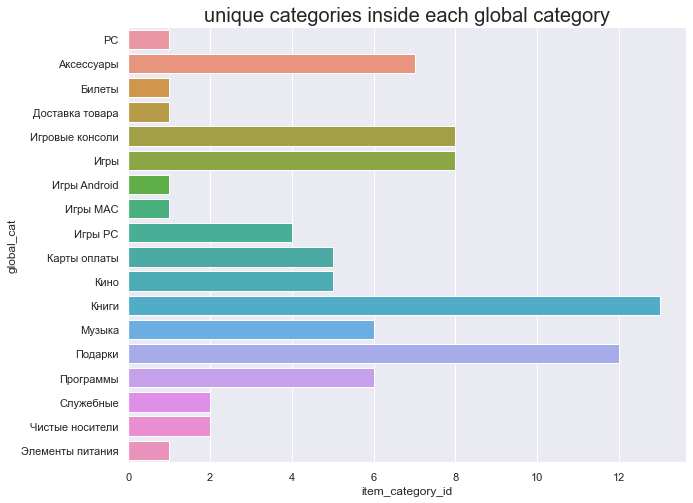

In [17]:
sns.set(rc={'figure.figsize':(10,8)})
sns.barplot(data=sales_merged.groupby('global_cat')['item_category_id'].nunique().reset_index(),y='global_cat', x='item_category_id')
plt.title('unique categories inside each global category', fontsize=20);

#### Price and Item Count

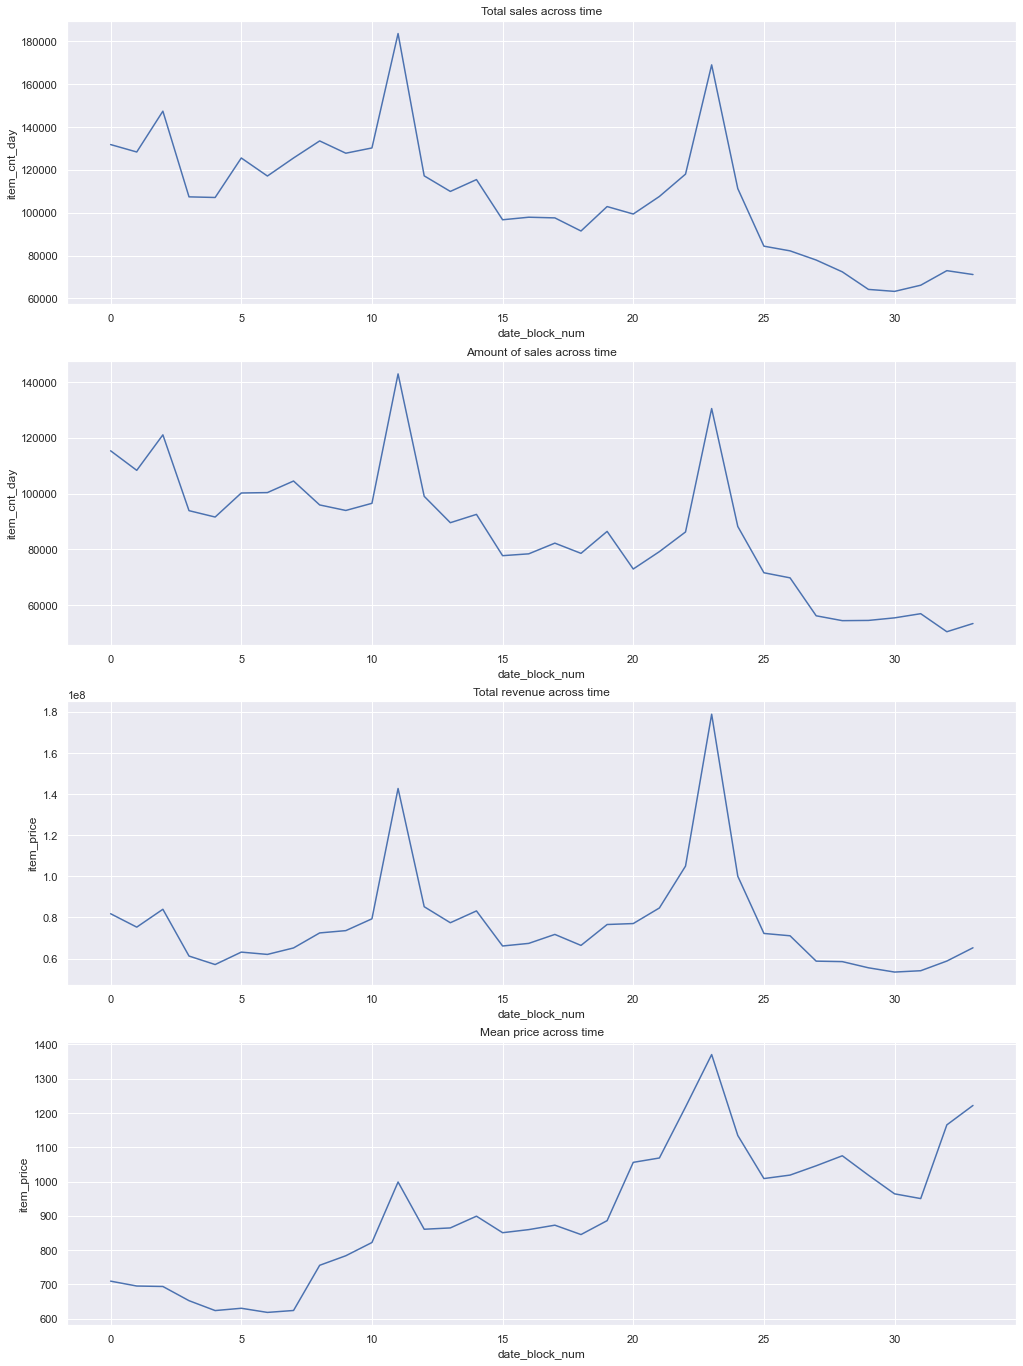

In [25]:
fig, axs = plt.subplots(nrows=4)
sns.set(rc={'figure.figsize':(18,24)})
sns.lineplot(data=sales_merged.groupby(['date_block_num'], as_index=False).agg({'item_cnt_day':'sum'}), y='item_cnt_day', x='date_block_num', ax=axs[0]);
axs[0].set_title('Total sales across time')
sns.lineplot(data=sales_merged.groupby(['date_block_num'], as_index=False).agg({'item_cnt_day':'count'}), y='item_cnt_day', x='date_block_num',ax=axs[1]);
axs[1].set_title('Amount of sales across time')
sns.lineplot(data=sales_merged.groupby(['date_block_num'], as_index=False).agg({'item_price':'sum'}), y='item_price', x='date_block_num', ax=axs[2]);
axs[2].set_title('Total revenue across time')
sns.lineplot(data=sales_merged.groupby(['date_block_num'], as_index=False).agg({'item_price':'mean'}), y='item_price', x='date_block_num', ax=axs[3]);
axs[3].set_title('Mean price across time');

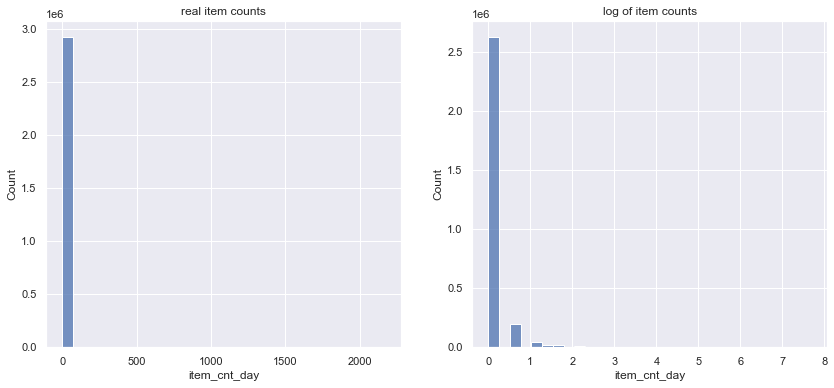

In [39]:
fig, axs = plt.subplots(ncols=2)
sns.set(rc={'figure.figsize':(12,6)})
sns.histplot(data=sales_merged, x='item_cnt_day', bins=30, ax=axs[0]);
log_cnt_day = np.log(sales_merged['item_cnt_day']).where(sales_merged['item_cnt_day'] > 0)
sns.histplot(data=log_cnt_day, bins=30, ax=axs[1])
axs[0].set_title('real item counts')
axs[1].set_title('log of item counts');

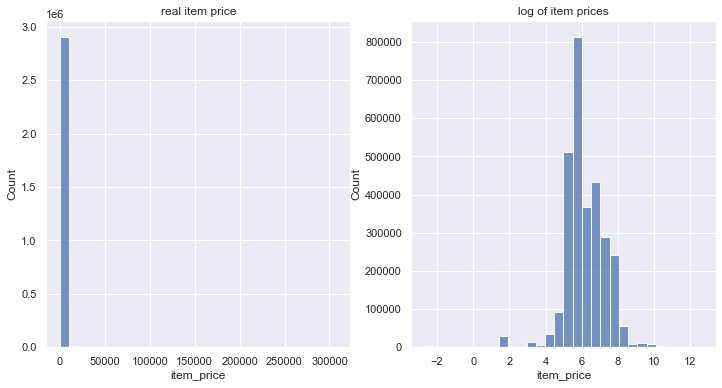

In [40]:
fig, axs = plt.subplots(ncols=2)
sns.set(rc={'figure.figsize':(12,6)})
sns.histplot(data=sales_merged, x='item_price', bins=30, ax=axs[0]);
log_cnt_day = np.log(sales_merged['item_price']).where(sales_merged['item_price'] > 0)
sns.histplot(data=log_cnt_day, bins=30, ax=axs[1])
axs[0].set_title('real item price')
axs[1].set_title('log of item prices');

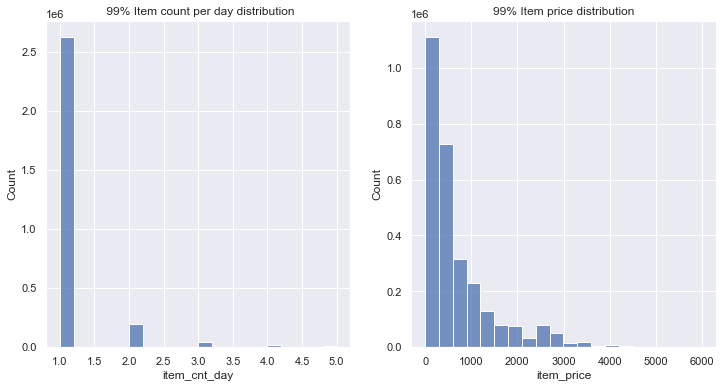

In [41]:
fig, axs = plt.subplots(ncols=2)
sns.set(rc={'figure.figsize':(12,6)})
sns.histplot(data=sales[sales['item_cnt_day'] <= sales['item_cnt_day'].quantile(.99)], x='item_cnt_day', bins=20, ax=axs[0]).set(title=' 99% Item count per day distribution');
sns.histplot(data=sales[sales['item_price'] <= sales['item_price'].quantile(.99)], x='item_price', bins=20, ax=axs[1]).set(title='99% Item price distribution');